In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from counterfactuals.cf_methods import PPCEF
from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.orchestrator import MetricsOrchestrator
from counterfactuals.models import MaskedAutoregressiveFlow
from counterfactuals.models.classifier.multilayer_perceptron import MLPClassifier
from counterfactuals.plotting.counterfactual_visualization import plot_counterfactuals

In [5]:
# Prepare the data
dataset = FileDataset(config_path="config/datasets/moons.yaml")

# Get the split data that's already available
X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Train a discriminative model
num_inputs = X_train.shape[1]
num_targets = 1

In [6]:
discriminative_model = MLPClassifier(
    num_inputs, num_targets, [128, 128, 128], dropout=0.0
)
discriminative_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)

Epoch 389, Train: 0.0069, test: 0.0019, patience: 300:   8%|▊         | 390/5000 [00:08<01:39, 46.21it/s]


In [7]:
# Train a generative model
num_inputs = X_train.shape[1]
num_targets = 1

generative_model = MaskedAutoregressiveFlow(
    features=num_inputs,
    hidden_features=128,
    context_features=num_targets,
)
generative_model.fit(
    train_dataloader, test_dataloader, epochs=100, patience=600, lr=0.01
)
log_prob_threshold = np.median(generative_model.predict_log_prob(test_dataloader))

Epoch 99, Train: 1.0509, test: 1.0636, patience: 86: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s] 


In [8]:
X_test_orig = X_test[y_test == 0]
y_test_orig = y_test[y_test == 0]

cf_dataset = TensorDataset(
    torch.tensor(X_test_orig, dtype=torch.float32),
    torch.tensor(y_test_orig, dtype=torch.float32),
)

In [7]:
cf_dataloader = DataLoader(cf_dataset, batch_size=1024, shuffle=False)


cf_method = PPCEF(
    disc_model=discriminative_model,
    gen_model=generative_model,
    disc_model_criterion=BinaryDiscLoss(),
)

results = cf_method.explain_dataloader(
    cf_dataloader,
    alpha=100,
    log_prob_threshold=log_prob_threshold,
    epochs=5000,
    patience=600,
    lr=0.001,
)

Discriminator loss: 0.0000, Prob loss: 0.0000: 100%|██████████| 5000/5000 [00:13<00:00, 371.78it/s]


In [8]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results.x_cfs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path="../config/metrics/plausibility.yaml",
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 10:10:11,535 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 89 valid


In [9]:
metrics

{'coverage': 1.0,
 'validity': 0.898989898989899,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 1.6462534876985282,
 'proximity_categorical_jaccard': 1.6462534876985282,
 'proximity_continuous_manhattan': 2.0997158759724184,
 'proximity_continuous_euclidean': 1.6462534876985282,
 'proximity_continuous_mad': 4.3701600198007995,
 'proximity_l2_jaccard': 1.6462534876985282,
 'proximity_mad_hamming': 4.3701600198007995,
 'prob_plausibility': 0.1414141414141414,
 'log_density_cf': -16.377726,
 'log_density_test': -0.4899645,
 'lof_scores_cf': 1.9573091333260966,
 'lof_scores_test': 1.0721709410716256,
 'isolation_forest_scores_cf': -0.05107824938331373,
 'isolation_forest_scores_test': 0.00497389017100576}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/ML-in-PL-counterfactuals/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


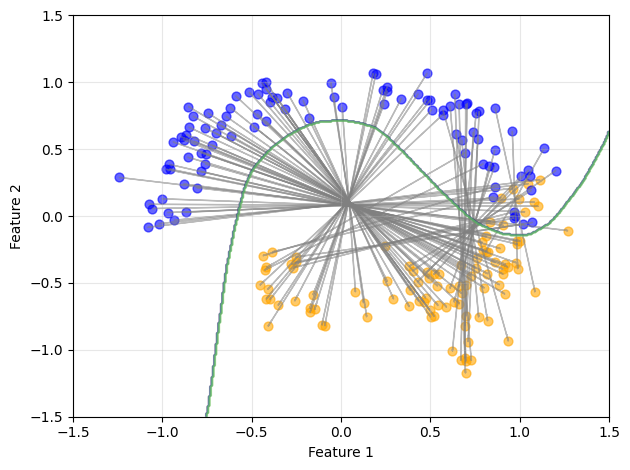

In [10]:
plot_counterfactuals(
    X_test_orig,
    results.x_cfs,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)

In [20]:
from counterfactuals.cf_methods import CCHVAE

input_size = dataset.X_train.shape[1]

cf_method = CCHVAE(
    discriminative_model=discriminative_model,
    dataset=dataset,
    hyperparams={
        "data_name": "moons",
        "vae_params": {"layers": [input_size, 64, 32, 16]},
        "epochs": 15,
    },
)
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test != target_class]
y_test_origin = dataset.y_test[dataset.y_test != target_class]

results = cf_method.get_counterfactuals(X_test_origin)
results_arr = results.to_numpy()

2025-10-17 11:24:39,199 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - Start training of Variational Autoencoder...
2025-10-17 11:24:39,220 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [Epoch: 0/5] [objective: 44.444]
2025-10-17 11:24:39,220 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.44]
2025-10-17 11:24:39,239 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.55]
2025-10-17 11:24:39,258 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.29]
2025-10-17 11:24:39,278 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.27]
2025-10-17 11:24:39,297 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.4]
2025-10-17 11:24:39,298 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - ... finished training of Variational Autoencoder.


In [21]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results_arr,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path="counterfactuals/pipelines/conf/metrics/default.yaml",
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 11:25:04,086 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 72 valid


In [22]:
metrics

{'coverage': 1.0,
 'validity': 0.7272727272727273,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 0.7316157692283229,
 'proximity_categorical_jaccard': 0.7316157692283229,
 'proximity_continuous_manhattan': 0.9486058414850815,
 'proximity_continuous_euclidean': 0.7316157692283229,
 'proximity_continuous_mad': 5.238853857073766,
 'proximity_l2_jaccard': 0.7316157692283229,
 'proximity_mad_hamming': 5.238853857073766,
 'prob_plausibility': 0.0,
 'log_density_cf': -6.6027966,
 'log_density_test': -0.72773373,
 'lof_scores_cf': 1.1522994330861145,
 'lof_scores_test': 7.465194310781295,
 'isolation_forest_scores_cf': 0.026229271514757152,
 'isolation_forest_scores_test': -0.09829707737692372}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


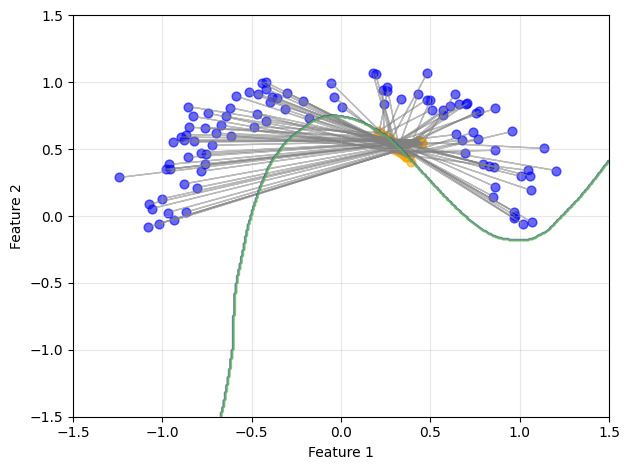

In [19]:
plot_counterfactuals(
    X_test_orig,
    results_arr,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)

In [16]:
import importlib

GLOBE_CE = getattr(
    importlib.import_module("counterfactuals.cf_methods.global.globe_ce.globe_ce"),
    "GLOBE_CE",
)


def predict_fn(X: np.ndarray) -> np.ndarray:
    return discriminative_model.predict(X)


globe_ce = GLOBE_CE(
    discriminative_model=discriminative_model,
    dataset=dataset,
    X=X_test_orig,
)
counterfactuals_unscaled = globe_ce.get_counterfactuals()

100%|██████████| 1000/1000 [00:00<00:00, 10612.23it/s]

Unable to find recourse for 0/99 inputs


In [20]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=counterfactuals_unscaled,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path="counterfactuals/pipelines/conf/metrics/default.yaml",
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 10:57:54,624 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 99 valid


In [21]:
metrics

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 0.9447453087646643,
 'proximity_categorical_jaccard': 0.9447453087646643,
 'proximity_continuous_manhattan': 1.0499965406546485,
 'proximity_continuous_euclidean': 0.9447453087646643,
 'proximity_continuous_mad': 1.9348553758264615,
 'proximity_l2_jaccard': 0.9447453087646643,
 'proximity_mad_hamming': 1.9348553758264615,
 'prob_plausibility': 0.0,
 'log_density_cf': -10.403004,
 'log_density_test': -0.73111916,
 'lof_scores_cf': 1.9832690796068786,
 'lof_scores_test': 1.0721709410716256,
 'isolation_forest_scores_cf': -0.05725589582711865,
 'isolation_forest_scores_test': 0.00497389017100576}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


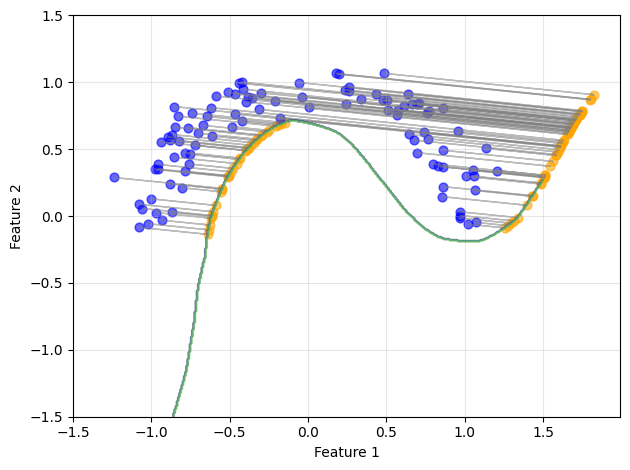

In [22]:
plot_counterfactuals(
    X_test_orig,
    counterfactuals_unscaled,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)